In [1]:
from helpers import *
device_in_use = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device_in_use)

Using device: cpu


In [2]:
# Define a transform to convert the data to a PyTorch Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download the training data
train_dataset = MNIST(root='../mnist_data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='../mnist_data', train=False, download=True, transform=transform)

trainset = HomographyDataset(train_dataset)
testset =HomographyDataset(test_dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

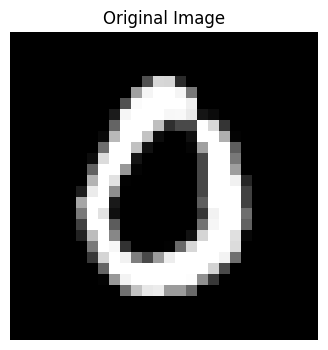

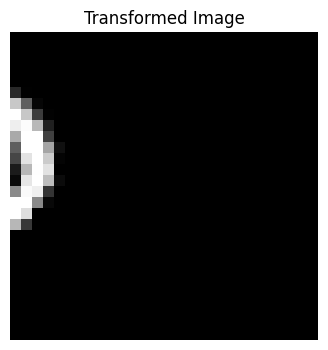

scale 1.129721595215361 0.9309302613867557
translation -9.797533318718784 -7.94982270766702
perspective 0.006372462199525205 0.006868551300483478
angle -26.162453783525628


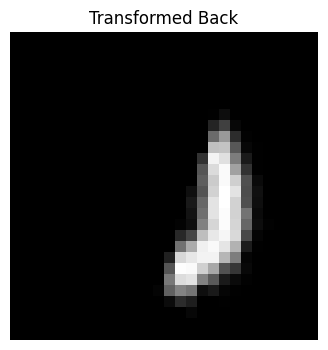

In [3]:
dataiter = iter(testloader)
image_tensor, norm_img_tensor, transformed_tensor, norm_transformed, inverse, inverse_flattened, ((sx,sy), (tx,ty), (g,h), angle) = next(dataiter)

# Display the first original image
plt.figure(figsize=(4, 4))
imshow(image_tensor[0])
plt.title('Original Image')
plt.show()

# Display the first rotated image
plt.figure(figsize=(4, 4))
imshow(transformed_tensor[0])
plt.title(f'Transformed Image')
plt.show()

print("scale", sx[0].item(), sy[0].item())
print("translation", tx[0].item(), ty[0].item())
print("perspective",g[0].item(), h[0].item())
print("angle",angle[0].item())

img = tensor_to_cv(transformed_tensor[0])
inv = inverse[0].numpy()
img_tran = cv2.warpPerspective(img, inv, (28,28))

# Display the first rotated image
plt.figure(figsize=(4, 4))
imshow(cv_to_tensor(img_tran))
plt.title(f'Transformed Back')
plt.show()

In [4]:
m1 = models.resnet18()

# Change the first convolutional layer to accept 1-channel input
m1.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

num_features = m1.fc.in_features
m1.fc = nn.Linear(num_features, 9)

# Now move the modified model to the GPU
m1 = m1.to(device_in_use)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_function = nn.MSELoss()

import torch.optim.lr_scheduler as lr_scheduler

# Define the StepLR scheduler
# This will decrease the learning rate by a factor of 0.1 every 30 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
train_loss = []
test_loss = []

epochs=500
early_stopping=EarlyStopping(patience=6, verbose=True, mode='min')
for epoch in range(epochs):
    m1.train()
    total_loss_train = 0  # Initialize total training loss
    for image_tensor, norm_img_tensor, transformed_tensor, norm_transformed, inverse, inverse_flattened, ((sx,sy), (tx,ty), (g,h), angle) in trainloader:
        # Move inputs to the device
        norm_transformed = norm_transformed.to(device_in_use)
        inverse = inverse_flattened.to(device_in_use)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = m1(norm_transformed).squeeze()

        # Calculate the loss
        loss = loss_function(outputs, inverse)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()  # Accumulate the training loss

    avg_loss_train = total_loss_train / len(trainloader)  # Compute the average training loss

    train_loss.append(avg_loss_train)

    m1.eval()
    total_loss_test = 0  # Initialize total test loss
    with torch.no_grad():
        for image_tensor, norm_img_tensor, transformed_tensor, norm_transformed, inverse, inverse_flattened, ((sx,sy), (tx,ty), (g,h), angle) in testloader:
            # Move inputs to the device
            norm_transformed = norm_transformed.to(device_in_use)
            inverse = inverse_flattened.to(device_in_use)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = m1(norm_transformed).squeeze()

            # Calculate the loss
            loss_test = loss_function(outputs, inverse)

            total_loss_test += loss_test.item()  # Accumulate the test loss

    avg_loss_test = total_loss_test / len(testloader) 

    test_loss.append(avg_loss_test)

    scheduler.step()

    early_stopping(avg_loss_test)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch [{epoch+1}/{epochs}], TRAIN | Loss: {avg_loss_train}, TEST | Loss: {avg_loss_test}')

torch.save(m1, 'working.pth')

In [ ]:
dataiter = iter(testloader)

m1.eval()

image_tensor, norm_img_tensor, transformed_tensor, norm_transformed, inverse, inverse_flattened, ((sx,sy), (tx,ty), (g,h), angle)  = next(dataiter)

original_image = image_tensor[0]
transformed_image = transformed_tensor[0]
norm_transformed_image = norm_transformed[0]
inverse = inverse[0].numpy()

original_image_batched = original_image.unsqueeze(0)
norm_transformed_image = norm_transformed_image.unsqueeze(0)

norm_transformed_image_batched = norm_transformed_image.to(device_in_use)

with torch.no_grad():
    outputs = m1(norm_transformed_image_batched).cpu()

transformed_image_cv = tensor_to_cv(transformed_image)
original_image_cv = tensor_to_cv(original_image)

outputs = outputs.cpu()

# Assuming 'outputs' contains the 8 parameters of the transformation matrix
predicted_params = outputs[0].numpy()  # Convert to numpy array if it's not already
predicted_inverse_matrix = predicted_params.reshape((3, 3))  # Append 1 for the last element and reshape


# Apply the predicted inverse transformation to the transformed image
# Note: 'cv_image' is obtained from 'tensor_to_cv(transformed_image.cpu())', as in your code
pred_restored = cv2.warpPerspective(transformed_image_cv, predicted_inverse_matrix, (transformed_image_cv.shape[0], transformed_image_cv.shape[1]))
actual_restored = cv2.warpPerspective(transformed_image_cv, inverse, (transformed_image_cv.shape[0], transformed_image_cv.shape[1]))

# Display the original transformed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(transformed_image_cv, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')

# Display the restored image using the predicted inverse matrix
plt.subplot(1, 4, 2)
plt.imshow(pred_restored, cmap='gray')
plt.title('Restored Image (PREDICTED)')
plt.axis('off')

#Display the actual restored image
plt.subplot(1, 4, 3)
plt.imshow(actual_restored, cmap='gray')
plt.title('Restored Image (ACTUAL)')
plt.axis('off')

# Optionally, display the original image for comparison
plt.subplot(1, 4, 4)
plt.imshow(original_image_cv, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.show()